In [1]:
#! pip install tensorflow[and-cuda]

In [2]:
import os
import cv2
import copy
import time
import tqdm
import warnings
import matplotlib
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics, preprocessing

2024-09-05 18:55:21.405240: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-05 18:55:21.416293: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-05 18:55:21.419352: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-05 18:55:21.428082: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-05 18:55:22.093053: W tensorflow/compiler/tf2

In [3]:
os.environ["KERAS_BACKEND"] = "tensorflow" 

In [4]:
path_folder = 'images/cebolinha'

size = 224
data = []
label = []
data_names = []
id = 0
for folder in tqdm.tqdm(os.listdir(path_folder)):
  for files in tqdm.tqdm(os.listdir(os.path.join(path_folder, folder))):
    if files.endswith('jpg'):
      label.append(folder)
      img_path = os.path.join(path_folder, folder, files)
      data_names.append((id, img_path))
      img = cv2.imread(img_path, cv2.IMREAD_COLOR)
      im = cv2.resize(img, (size, size))
      data.append(im)
      id += 1

100%|██████████| 5/5 [00:00<00:00,  5.54it/s]


In [5]:
data = np.array(data)/255

In [6]:
le = preprocessing.LabelEncoder()
y = le.fit_transform(label)
y = tf.keras.utils.to_categorical(y)

In [7]:
data.shape

(358, 224, 224, 3)

In [8]:
y.shape

(358, 5)

In [9]:
len(data_names)

358

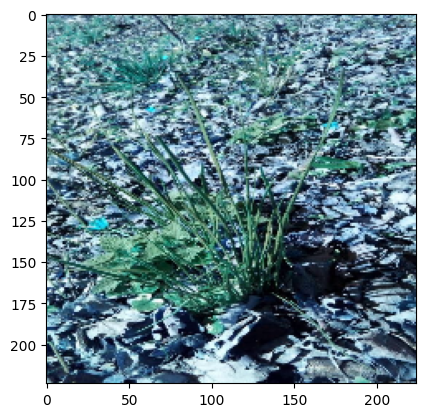

In [10]:
plt.imshow(data[0])

In [11]:
def plot_img(id):
  img_label = label[id]
  img = data[id]
  plt.imshow(img)
  plt.title(img_label)  

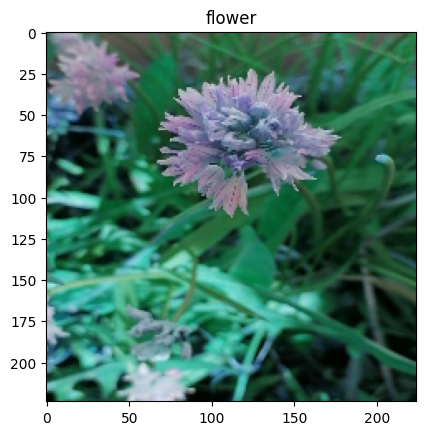

In [12]:
rnd = np.random.randint(0, len(data))
plot_img(rnd)

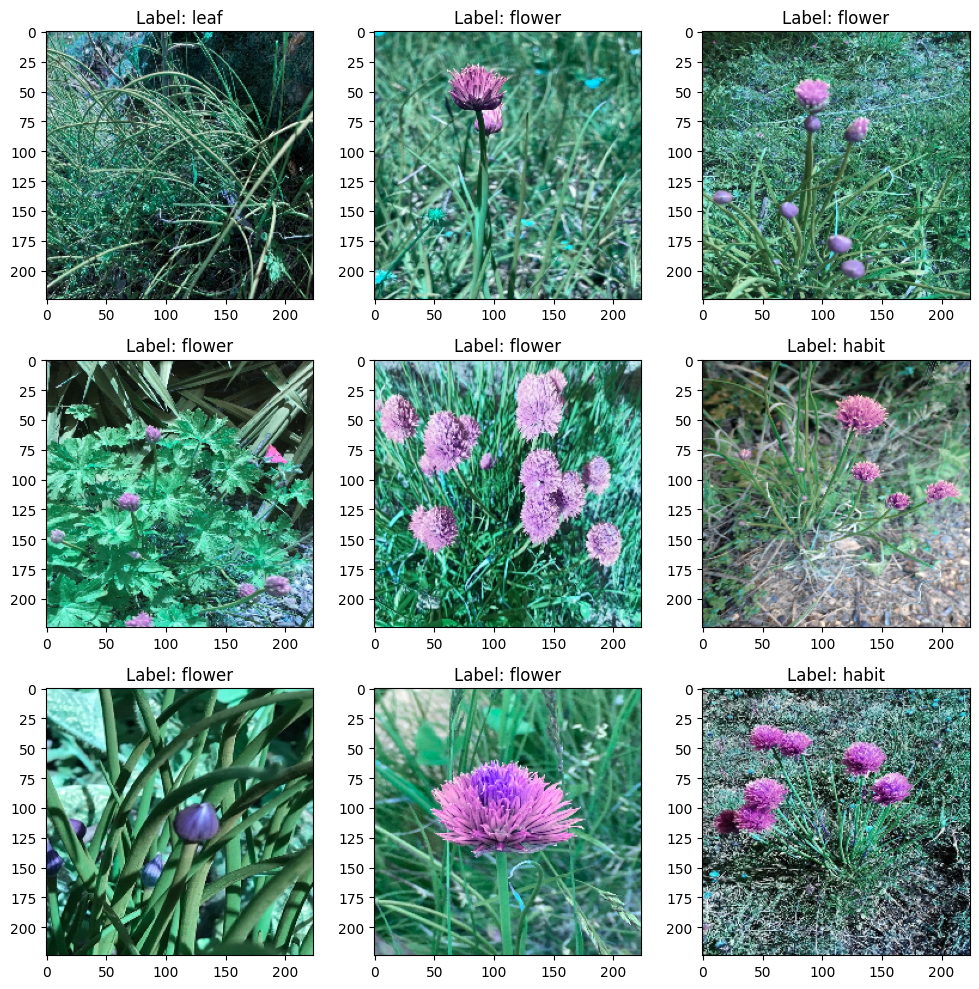

In [13]:
row=3
col=3
fig, ax = plt.subplots(row, col)
fig.set_size_inches(10, 10)
for r in range(row):
  for c in range(col):
    rnd = np.random.randint(0, len(data))
    ax[r, c].imshow(data[rnd])
    ax[r, c].set_title(f'Label: {label[rnd]}')
plt.tight_layout()

In [14]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(data, y, random_state=42, test_size=0.25)

In [15]:
base_model = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='avg')

I0000 00:00:1725573325.075919   26680 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725573325.098490   26680 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725573325.098552   26680 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725573325.100907   26680 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725573325.100955   26680 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [16]:
model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(5, activation='softmax'))
base_model.trainable=False

In [17]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 512)            │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,156,997 (76.89 MB)

 Trainable params: 132,613 (518.02 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [19]:
history = model.fit(x_train,
                     y_train,
                     batch_size=32,
                     epochs=120,
                     validation_data=(x_test, y_test),
                     verbose=1,
                     steps_per_epoch=x_train.shape[0]//32)

Epoch 1/120


I0000 00:00:1725573327.086836   26794 service.cc:146] XLA service 0x7fa5d0106870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725573327.086874   26794 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-09-05 18:55:27.108549: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-05 18:55:27.251442: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-09-05 18:55:28.593629: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1477', 36 bytes spill stores, 40 bytes spill loads

2024-09-05 18:55:29.017468: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in functi

3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.0174 - loss: 2.0176    

I0000 00:00:1725573336.106756   26794 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.0163 - loss: 1.9968 - val_accuracy: 0.0222 - val_loss: 1.9431
Epoch 2/120
1/8 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.0833 - loss: 1.8794

2024-09-05 18:55:48.616074: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-05 18:55:48.616126: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-09-05 18:55:48.616141: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2746930106387114841
2024-09-05 18:55:48.616167: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12689949955175964307
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, trac

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.0833 - loss: 1.8794 - val_accuracy: 0.0222 - val_loss: 1.9382
Epoch 3/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.0185 - loss: 1.9424 - val_accuracy: 0.0222 - val_loss: 1.8999
Epoch 4/120
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.0000e+00 - loss: 1.8657

2024-09-05 18:55:49.653039: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.0000e+00 - loss: 1.8657 - val_accuracy: 0.0222 - val_loss: 1.8952
Epoch 5/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.0140 - loss: 1.8900 - val_accuracy: 0.0222 - val_loss: 1.8580
Epoch 6/120
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.0000e+00 - loss: 1.8835

2024-09-05 18:55:50.667693: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2746930106387114841
2024-09-05 18:55:50.667756: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12689949955175964307


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.0000e+00 - loss: 1.8835 - val_accuracy: 0.0222 - val_loss: 1.8532
Epoch 7/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.0125 - loss: 1.8470 - val_accuracy: 0.0222 - val_loss: 1.8164
Epoch 8/120
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.0833 - loss: 1.7682

2024-09-05 18:55:51.665499: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-09-05 18:55:51.665544: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2746930106387114841
2024-09-05 18:55:51.665574: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12689949955175964307


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.0833 - loss: 1.7682 - val_accuracy: 0.0222 - val_loss: 1.8119
Epoch 9/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.0215 - loss: 1.7946 - val_accuracy: 0.0222 - val_loss: 1.7765
Epoch 10/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.0000e+00 - loss: 1.7406 - val_accuracy: 0.0222 - val_loss: 1.7724
Epoch 11/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.0126 - loss: 1.7617 - val_accuracy: 0.0222 - val_loss: 1.7378
Epoch 12/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.0000e+00 - loss: 1.7090 - val_accuracy: 0.0222 - val_loss: 1.7336
Epoch 13/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.0145 - loss: 1.7081 - val_accuracy: 0.0222 - val_loss: 1.7000
Epoch 14/120
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.0000e+00 - loss: 1.7396

2024-09-05 18:55:54.674213: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2746930106387114841


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.0000e+00 - loss: 1.7396 - val_accuracy: 0.0222 - val_loss: 1.6961
Epoch 15/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.0152 - loss: 1.6612 - val_accuracy: 0.0222 - val_loss: 1.6643
Epoch 16/120
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.0000e+00 - loss: 1.5968

2024-09-05 18:55:55.674685: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-09-05 18:55:55.674730: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2746930106387114841
2024-09-05 18:55:55.674761: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12689949955175964307


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.0000e+00 - loss: 1.5968 - val_accuracy: 0.0222 - val_loss: 1.6603
Epoch 17/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.0123 - loss: 1.6341 - val_accuracy: 0.0222 - val_loss: 1.6291
Epoch 18/120
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.0000e+00 - loss: 1.5689

2024-09-05 18:55:56.687406: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2746930106387114841
2024-09-05 18:55:56.687466: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12689949955175964307


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.0000e+00 - loss: 1.5689 - val_accuracy: 0.0222 - val_loss: 1.6254
Epoch 19/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.0115 - loss: 1.5833 - val_accuracy: 0.0222 - val_loss: 1.5955
Epoch 20/120
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.0000e+00 - loss: 1.5956

2024-09-05 18:55:57.701685: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2746930106387114841
2024-09-05 18:55:57.701748: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12689949955175964307


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.0000e+00 - loss: 1.5956 - val_accuracy: 0.0222 - val_loss: 1.5919
Epoch 21/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.0370 - loss: 1.5445 - val_accuracy: 0.0333 - val_loss: 1.5631
Epoch 22/120
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.1667 - loss: 1.4507

2024-09-05 18:55:58.708803: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2746930106387114841
2024-09-05 18:55:58.708866: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12689949955175964307


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.1667 - loss: 1.4507 - val_accuracy: 0.0444 - val_loss: 1.5596
Epoch 23/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.0571 - loss: 1.5255 - val_accuracy: 0.0889 - val_loss: 1.5321
Epoch 24/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2500 - loss: 1.3972 - val_accuracy: 0.1111 - val_loss: 1.5287
Epoch 25/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.1810 - loss: 1.4639 - val_accuracy: 0.2000 - val_loss: 1.5017
Epoch 26/120
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3333 - loss: 1.3467

2024-09-05 18:56:00.702609: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2746930106387114841
2024-09-05 18:56:00.702680: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12689949955175964307


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3333 - loss: 1.3467 - val_accuracy: 0.2111 - val_loss: 1.4985
Epoch 27/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.3404 - loss: 1.4321 - val_accuracy: 0.3000 - val_loss: 1.4733
Epoch 28/120
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3333 - loss: 1.4940

2024-09-05 18:56:01.719770: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2746930106387114841
2024-09-05 18:56:01.719830: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12689949955175964307


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3333 - loss: 1.4940 - val_accuracy: 0.3222 - val_loss: 1.4701
Epoch 29/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.5249 - loss: 1.3855 - val_accuracy: 0.4222 - val_loss: 1.4456
Epoch 30/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4167 - loss: 1.2976 - val_accuracy: 0.4667 - val_loss: 1.4425
Epoch 31/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.6007 - loss: 1.3500 - val_accuracy: 0.5778 - val_loss: 1.4188
Epoch 32/120
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8333 - loss: 1.3676

2024-09-05 18:56:03.693227: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-09-05 18:56:03.693280: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2746930106387114841
2024-09-05 18:56:03.693316: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12689949955175964307


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8333 - loss: 1.3676 - val_accuracy: 0.5889 - val_loss: 1.4159
Epoch 33/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.6620 - loss: 1.3380 - val_accuracy: 0.6111 - val_loss: 1.3938
Epoch 34/120
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6667 - loss: 1.3608

2024-09-05 18:56:04.690562: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2746930106387114841
2024-09-05 18:56:04.690622: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12689949955175964307


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6667 - loss: 1.3608 - val_accuracy: 0.6111 - val_loss: 1.3911
Epoch 35/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.7231 - loss: 1.3019 - val_accuracy: 0.6111 - val_loss: 1.3696
Epoch 36/120
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5833 - loss: 1.4653

2024-09-05 18:56:05.674096: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2746930106387114841
2024-09-05 18:56:05.674155: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12689949955175964307


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5833 - loss: 1.4653 - val_accuracy: 0.6111 - val_loss: 1.3669
Epoch 37/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.7193 - loss: 1.2704 - val_accuracy: 0.6111 - val_loss: 1.3470
Epoch 38/120
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5833 - loss: 1.2891

2024-09-05 18:56:06.665272: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2746930106387114841
2024-09-05 18:56:06.665333: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12689949955175964307


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5833 - loss: 1.2891 - val_accuracy: 0.6111 - val_loss: 1.3444
Epoch 39/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.7256 - loss: 1.2525 - val_accuracy: 0.6111 - val_loss: 1.3247
Epoch 40/120
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8333 - loss: 1.2094

2024-09-05 18:56:07.674194: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2746930106387114841
2024-09-05 18:56:07.674257: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12689949955175964307


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8333 - loss: 1.2094 - val_accuracy: 0.6111 - val_loss: 1.3223
Epoch 41/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.7524 - loss: 1.2080 - val_accuracy: 0.6111 - val_loss: 1.3038
Epoch 42/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6667 - loss: 1.1667 - val_accuracy: 0.6111 - val_loss: 1.3015
Epoch 43/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.7211 - loss: 1.2020 - val_accuracy: 0.6111 - val_loss: 1.2835
Epoch 44/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8333 - loss: 1.1705 - val_accuracy: 0.6111 - val_loss: 1.2814


2024-09-05 18:56:09.681290: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2746930106387114841
2024-09-05 18:56:09.681351: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12689949955175964307


Epoch 45/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.7121 - loss: 1.1784 - val_accuracy: 0.6111 - val_loss: 1.2645
Epoch 46/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7500 - loss: 1.2160 - val_accuracy: 0.6111 - val_loss: 1.2626
Epoch 47/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.7159 - loss: 1.1584 - val_accuracy: 0.6111 - val_loss: 1.2468
Epoch 48/120
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9167 - loss: 1.0254

2024-09-05 18:56:11.649872: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2746930106387114841
2024-09-05 18:56:11.649932: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12689949955175964307


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9167 - loss: 1.0254 - val_accuracy: 0.6111 - val_loss: 1.2448
Epoch 49/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.7382 - loss: 1.1216 - val_accuracy: 0.6111 - val_loss: 1.2299
Epoch 50/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6667 - loss: 1.2420 - val_accuracy: 0.6111 - val_loss: 1.2281
Epoch 51/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.7414 - loss: 1.1009 - val_accuracy: 0.6111 - val_loss: 1.2141
Epoch 52/120
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6667 - loss: 1.0753

2024-09-05 18:56:13.633231: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2746930106387114841
2024-09-05 18:56:13.633291: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12689949955175964307


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6667 - loss: 1.0753 - val_accuracy: 0.6111 - val_loss: 1.2124
Epoch 53/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.7020 - loss: 1.1127 - val_accuracy: 0.6111 - val_loss: 1.1987
Epoch 54/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8333 - loss: 0.9700 - val_accuracy: 0.6111 - val_loss: 1.1971
Epoch 55/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.7137 - loss: 1.0873 - val_accuracy: 0.6111 - val_loss: 1.1843
Epoch 56/120
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7500 - loss: 1.0301

2024-09-05 18:56:15.641182: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2746930106387114841
2024-09-05 18:56:15.641253: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12689949955175964307


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7500 - loss: 1.0301 - val_accuracy: 0.6111 - val_loss: 1.1828
Epoch 57/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.6880 - loss: 1.0872 - val_accuracy: 0.6111 - val_loss: 1.1708
Epoch 58/120
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7500 - loss: 1.0563

2024-09-05 18:56:16.631044: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2746930106387114841


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7500 - loss: 1.0563 - val_accuracy: 0.6111 - val_loss: 1.1694
Epoch 59/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.7400 - loss: 1.0369 - val_accuracy: 0.6111 - val_loss: 1.1583
Epoch 60/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8333 - loss: 0.8754 - val_accuracy: 0.6111 - val_loss: 1.1570
Epoch 61/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.6889 - loss: 1.0517 - val_accuracy: 0.6111 - val_loss: 1.1461
Epoch 62/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6667 - loss: 1.1171 - val_accuracy: 0.6111 - val_loss: 1.1448
Epoch 63/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.7611 - loss: 0.9680 - val_accuracy: 0.6111 - val_loss: 1.1345
Epoch 64/120
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8333 - loss: 0.8877

2024-09-05 18:56:19.587829: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-09-05 18:56:19.587871: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2746930106387114841
2024-09-05 18:56:19.587901: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12689949955175964307


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8333 - loss: 0.8877 - val_accuracy: 0.6111 - val_loss: 1.1333
Epoch 65/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.7382 - loss: 0.9715 - val_accuracy: 0.6111 - val_loss: 1.1236
Epoch 66/120
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8333 - loss: 0.8698

2024-09-05 18:56:20.574190: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2746930106387114841
2024-09-05 18:56:20.574252: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12689949955175964307


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8333 - loss: 0.8698 - val_accuracy: 0.6111 - val_loss: 1.1225
Epoch 67/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.7279 - loss: 0.9677 - val_accuracy: 0.6111 - val_loss: 1.1134
Epoch 68/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5833 - loss: 1.0533 - val_accuracy: 0.6111 - val_loss: 1.1122
Epoch 69/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.7348 - loss: 0.9736 - val_accuracy: 0.6111 - val_loss: 1.1035
Epoch 70/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9167 - loss: 0.7382 - val_accuracy: 0.6111 - val_loss: 1.1026
Epoch 71/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.7360 - loss: 0.9337 - val_accuracy: 0.6111 - val_loss: 1.0943
Epoch 72/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8333 - loss: 0.8941 - val_accuracy: 0.6111 - val_loss: 1.0934
Epoch 73/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.6935 - loss: 1.0029 - val_accuracy: 0.6111 - val_loss: 1.08

2024-09-05 18:56:25.503582: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2746930106387114841
2024-09-05 18:56:25.503647: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12689949955175964307


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5833 - loss: 1.0271 - val_accuracy: 0.6111 - val_loss: 1.0769
Epoch 77/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.7208 - loss: 0.9431 - val_accuracy: 0.6111 - val_loss: 1.0696
Epoch 78/120
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8333 - loss: 0.7337

2024-09-05 18:56:26.484928: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2746930106387114841
2024-09-05 18:56:26.484985: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12689949955175964307


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8333 - loss: 0.7337 - val_accuracy: 0.6111 - val_loss: 1.0688
Epoch 79/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.7550 - loss: 0.8758 - val_accuracy: 0.6111 - val_loss: 1.0626
Epoch 80/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5000 - loss: 1.1752 - val_accuracy: 0.6111 - val_loss: 1.0618
Epoch 81/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.7091 - loss: 0.9404 - val_accuracy: 0.6111 - val_loss: 1.0551
Epoch 82/120
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7500 - loss: 0.8242

2024-09-05 18:56:28.459657: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2746930106387114841
2024-09-05 18:56:28.459717: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12689949955175964307


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7500 - loss: 0.8242 - val_accuracy: 0.6111 - val_loss: 1.0544
Epoch 83/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.7072 - loss: 0.9038 - val_accuracy: 0.6111 - val_loss: 1.0482
Epoch 84/120
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7500 - loss: 0.9217

2024-09-05 18:56:29.451329: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2746930106387114841
2024-09-05 18:56:29.451389: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12689949955175964307


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7500 - loss: 0.9217 - val_accuracy: 0.6111 - val_loss: 1.0475
Epoch 85/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.7245 - loss: 0.9027 - val_accuracy: 0.6111 - val_loss: 1.0421
Epoch 86/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5000 - loss: 1.2052 - val_accuracy: 0.6111 - val_loss: 1.0414
Epoch 87/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.7157 - loss: 0.8833 - val_accuracy: 0.6111 - val_loss: 1.0356
Epoch 88/120
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9167 - loss: 0.6556

2024-09-05 18:56:31.433073: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2746930106387114841
2024-09-05 18:56:31.433139: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12689949955175964307


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9167 - loss: 0.6556 - val_accuracy: 0.6111 - val_loss: 1.0349
Epoch 89/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.7485 - loss: 0.8336 - val_accuracy: 0.6111 - val_loss: 1.0302
Epoch 90/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8333 - loss: 0.6681 - val_accuracy: 0.6111 - val_loss: 1.0296
Epoch 91/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.7626 - loss: 0.8262 - val_accuracy: 0.6111 - val_loss: 1.0249
Epoch 92/120
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7500 - loss: 0.7685

2024-09-05 18:56:33.407976: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2746930106387114841
2024-09-05 18:56:33.408034: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12689949955175964307


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7500 - loss: 0.7685 - val_accuracy: 0.6111 - val_loss: 1.0243
Epoch 93/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.7355 - loss: 0.8520 - val_accuracy: 0.6111 - val_loss: 1.0196
Epoch 94/120
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7500 - loss: 0.7281

2024-09-05 18:56:34.425978: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2746930106387114841
2024-09-05 18:56:34.426051: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12689949955175964307


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7500 - loss: 0.7281 - val_accuracy: 0.6111 - val_loss: 1.0191
Epoch 95/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.7576 - loss: 0.8047 - val_accuracy: 0.6111 - val_loss: 1.0148
Epoch 96/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5000 - loss: 1.1005 - val_accuracy: 0.6111 - val_loss: 1.0142
Epoch 97/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.7389 - loss: 0.8021 - val_accuracy: 0.6111 - val_loss: 1.0093
Epoch 98/120
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6667 - loss: 0.8599

2024-09-05 18:56:36.402603: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2746930106387114841
2024-09-05 18:56:36.402661: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12689949955175964307


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6667 - loss: 0.8599 - val_accuracy: 0.6111 - val_loss: 1.0088
Epoch 99/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.7147 - loss: 0.8570 - val_accuracy: 0.6111 - val_loss: 1.0044
Epoch 100/120
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7500 - loss: 0.8313

2024-09-05 18:56:37.415191: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2746930106387114841
2024-09-05 18:56:37.415260: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12689949955175964307


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7500 - loss: 0.8313 - val_accuracy: 0.6111 - val_loss: 1.0039
Epoch 101/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.7167 - loss: 0.8438 - val_accuracy: 0.6111 - val_loss: 0.9997
Epoch 102/120
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8333 - loss: 0.8201

2024-09-05 18:56:38.436993: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2746930106387114841
2024-09-05 18:56:38.437065: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12689949955175964307


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8333 - loss: 0.8201 - val_accuracy: 0.6111 - val_loss: 0.9993
Epoch 103/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.7459 - loss: 0.8044 - val_accuracy: 0.6111 - val_loss: 0.9960
Epoch 104/120
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6667 - loss: 0.9843

2024-09-05 18:56:39.446035: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2746930106387114841
2024-09-05 18:56:39.446109: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12689949955175964307


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6667 - loss: 0.9843 - val_accuracy: 0.6111 - val_loss: 0.9956
Epoch 105/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.6983 - loss: 0.8579 - val_accuracy: 0.6111 - val_loss: 0.9916
Epoch 106/120
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7500 - loss: 0.9534

2024-09-05 18:56:40.436950: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2746930106387114841
2024-09-05 18:56:40.437011: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12689949955175964307


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7500 - loss: 0.9534 - val_accuracy: 0.6111 - val_loss: 0.9912
Epoch 107/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.7484 - loss: 0.7531 - val_accuracy: 0.6111 - val_loss: 0.9882
Epoch 108/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5833 - loss: 1.0995 - val_accuracy: 0.6111 - val_loss: 0.9877
Epoch 109/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.7506 - loss: 0.7750 - val_accuracy: 0.6111 - val_loss: 0.9844
Epoch 110/120
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5833 - loss: 0.9919

2024-09-05 18:56:42.454843: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2746930106387114841
2024-09-05 18:56:42.454909: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12689949955175964307


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5833 - loss: 0.9919 - val_accuracy: 0.6111 - val_loss: 0.9839
Epoch 111/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.7173 - loss: 0.8159 - val_accuracy: 0.6111 - val_loss: 0.9798
Epoch 112/120
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5833 - loss: 1.0866

2024-09-05 18:56:43.452513: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2746930106387114841
2024-09-05 18:56:43.452577: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12689949955175964307


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5833 - loss: 1.0866 - val_accuracy: 0.6111 - val_loss: 0.9793
Epoch 113/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.7410 - loss: 0.7763 - val_accuracy: 0.6111 - val_loss: 0.9760
Epoch 114/120
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6667 - loss: 0.9169

2024-09-05 18:56:44.468624: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2746930106387114841
2024-09-05 18:56:44.468695: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12689949955175964307


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6667 - loss: 0.9169 - val_accuracy: 0.6111 - val_loss: 0.9756
Epoch 115/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.7047 - loss: 0.8371 - val_accuracy: 0.6111 - val_loss: 0.9721
Epoch 116/120
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9167 - loss: 0.5077

2024-09-05 18:56:45.480171: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2746930106387114841
2024-09-05 18:56:45.480229: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12689949955175964307


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9167 - loss: 0.5077 - val_accuracy: 0.6111 - val_loss: 0.9717
Epoch 117/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.6992 - loss: 0.8297 - val_accuracy: 0.6111 - val_loss: 0.9688
Epoch 118/120
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7500 - loss: 0.9517

2024-09-05 18:56:46.489363: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2746930106387114841
2024-09-05 18:56:46.489424: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12689949955175964307


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7500 - loss: 0.9517 - val_accuracy: 0.6111 - val_loss: 0.9685
Epoch 119/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.7161 - loss: 0.8022 - val_accuracy: 0.6111 - val_loss: 0.9659
Epoch 120/120
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5833 - loss: 1.0102

2024-09-05 18:56:47.509239: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2746930106387114841
2024-09-05 18:56:47.509309: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12689949955175964307


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5833 - loss: 1.0102 - val_accuracy: 0.6111 - val_loss: 0.9656


In [20]:
def plot_history(history, loss=True):

  num_epochs = len(history['loss'])
  title = 'loss' if loss else 'accuracy'
  plt.title(f'Train Validation {title}')
  plt.plot(range(1, num_epochs+1), history[f'{title}'], label='Train')
  plt.plot(range(1, num_epochs+1), history[f'val_{title}'], label='Validation')
  plt.xlabel('Trainig Epochs')
  plt.ylabel(title)
  plt.legend()
  plt.grid()
  plt.show()

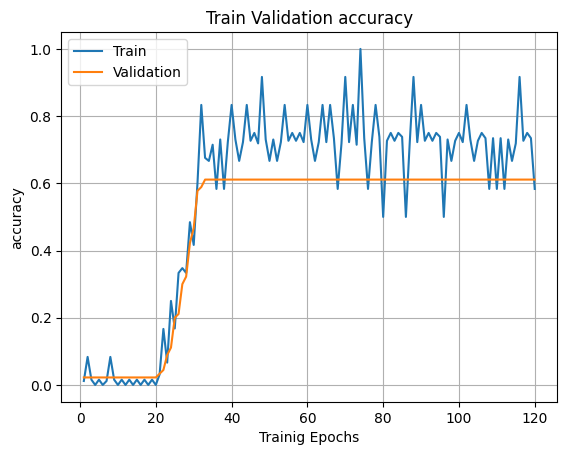

In [21]:
plot_history(history.history, False)

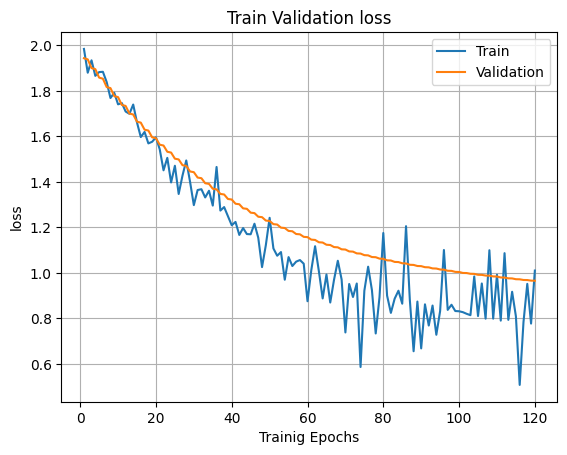

In [22]:
plot_history(history.history, True)

In [29]:
#model.save('model_cebolinha.h5', save_format = 'h5')
model.save('model_cebolinha.keras')